# Main figures in "Top-down connection in hierarchical sparse coding" for the ATT database
https://arxiv.org/abs/2002.00892

In [1]:
from SPC_2L.DataTools import DataBase, to_img, show
import pickle
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_FISTA, ML_Lasso
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torch
from torchvision.transforms import ToTensor,Compose
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torch.utils.data import DataLoader

## Tools, parameters and database

In [2]:
def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

In [3]:
data_path = '../DataSet/Face_DataBase/Face_DataBase_testing'

LCN_params = {'kernel_size':9,'sigma':0.5} # Local contrast normalization parameters

mask_params={'n': 10} # mask parameters

whitening_params={'f_0':0.5,'n':2} # Whitening parameters

Data_load_param = { 'batch_size': 20,
                    'gray_scale': True,
                    'do_LCN': True,
                    'LCN_params': LCN_params,
                    'do_mask': True,
                    'mask_params': mask_params,
                    'do_whitening': True,
                    'whitening_params': whitening_params,
                    'do_z_score': True,
                    'return_idx': False
                  }

Facedata = DataBase('from_ImageFolder', data_path, img_size=(112,92),**Data_load_param, shuffle=True)

save = False #### Use to re-run the entire simulation : TAKE HOURS. Use False to load previous simulation

range_b = [0,1] ## b=0 --> HiLa, b=1 --> 2L_SPC
range_lbda1 = [0.3 + i*0.1 for i in range(5)] ## range of tested lbda1
range_lbda2 = [0.6 + i*0.2 for i in range(6)] ## range of tested lbda2

model_name_list_l1_b0 = ['ATT_[{0:0.1f},1.0]_b={1:0.0f}'.format(lbda1,0) for lbda1 in range_lbda1]
model_name_list_l2_b0 = ['ATT_[0.5,{0:0.1f}]_b={1:0.0f}'.format(lbda2,0) for lbda2 in range_lbda2]

model_name_list_l1_b1 = ['ATT_[{0:0.1f},1.0]_b={1:0.0f}'.format(lbda1,1) for lbda1 in range_lbda1]
model_name_list_l2_b1 = ['ATT_[0.5,{0:0.1f}]_b={1:0.0f}'.format(lbda2,1) for lbda2 in range_lbda2]


cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')

## Save == True: Wrapping all  the exploration space in one file

In [4]:
exp_list = {'ATT_lbda1' : (model_name_list_l1_b0, model_name_list_l1_b1),
          'ATT_lbda2' : (model_name_list_l2_b0, model_name_list_l2_b1)
         }

if save == True : 
    for exp_idx, exp_name in enumerate(exp_list.keys()):
        file_to_save = 'Savings/ATT/' + str(exp_name) + '.pkl'
        
        Layer_wise_loss_SDPC = np.zeros((len(range_b),len(exp_list[exp_name][0]), 2))
        it_SDPC = np.zeros((len(range_b),len(exp_list[exp_name][0])))
        all_L2_loss = np.zeros((len(range_b),len(exp_list[exp_name][0]), 2))
        all_L1_loss = np.zeros((len(range_b),len(exp_list[exp_name][0]), 2))
        
        print(exp_list[exp_name])
        for idx_b, b in enumerate(range_b):
        
            for idx_model, model_name in enumerate(exp_list[exp_name][idx_b]):
                print(model_name)
                path = 'Savings/ATT/' + model_name +'.pkl'

                with open(path, 'rb') as file:
                    out = pickle.load(file)
                Net = out['Net']
                Loss = out['Loss']
                Pursuit = out['Pursuit'] 
                all_error = [0] * (Net.nb_layers)
                all_it = 0
                all_Loss = [0] * (Net.nb_layers)
                penalty = [None] * (Net.nb_layers)
                all_penalty = [0] * (Net.nb_layers)
                for idx_batch, data in enumerate(Facedata.data):
                    batch = data[0].cuda()
                    if idx_batch>20:
                        break
                    gamma, it, Loss_G, delta = Pursuit.coding(batch)
                    reco = reconstruction(Net,gamma)
                    error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
                    for i in range(Net.nb_layers):
                        all_Loss[i] += Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])

                    penalty = [Loss.lambdas[i]*gamma[i].abs().sum() for i in range(Net.nb_layers)]

                    for i in range(Net.nb_layers):
                        all_error [i] += error[i]
                    for i in range(Net.nb_layers):
                        all_penalty[i] += penalty[i]
                    all_it += it        

                for i in range(Net.nb_layers):
                    all_error[i] /= ((idx_batch+1)*batch.size(0))
                for i in range(Net.nb_layers):
                    all_Loss[i] /= ((idx_batch+1))    
                for i in range(Net.nb_layers):
                    all_penalty[i] /= ((idx_batch+1)*batch.size(0))    
                all_it /= (idx_batch+1)
                tot_loss = 0
                for i in range(Net.nb_layers):
                    tot_loss += all_Loss[i]+all_penalty[i]
                    Layer_wise_loss_SDPC[idx_b, idx_model,i]=all_Loss[i]+all_penalty[i]
                    all_L2_loss[idx_b, idx_model,i] = all_Loss[i]
                    all_L1_loss[idx_b, idx_model, i] = all_penalty[i]
                it_SDPC[idx_b, idx_model] = all_it 
            res_SDPC = {'loss': Layer_wise_loss_SDPC,
                      'it': it_SDPC,
                        'L2_loss':all_L2_loss,
                        'L1_loss':all_L1_loss}
            with open(file_to_save, 'wb') as file:
                pickle.dump(res_SDPC, file, pickle.HIGHEST_PROTOCOL)
        else : 
            with open(file_to_save, 'rb') as file:
                res_SDPC = pickle.load(file)



## Fig 2

In [5]:
with open('Savings/ATT/ATT_lbda1.pkl', 'rb') as file:
        res_exp_lbda1 = pickle.load(file)
        
with open('Savings/ATT/ATT_lbda2.pkl', 'rb') as file:
        res_exp_lbda2 = pickle.load(file)

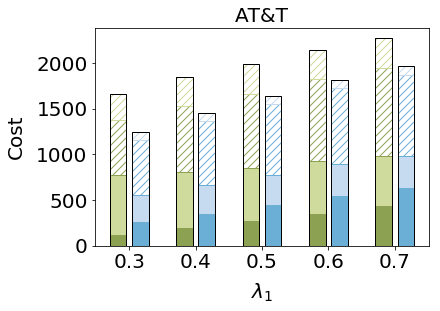

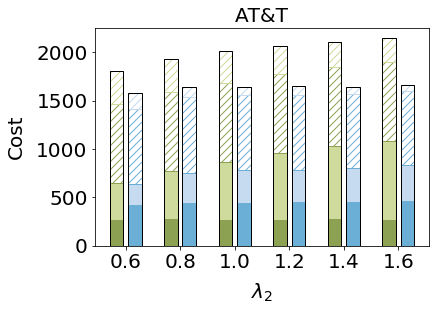

In [6]:
save_fig = True

width = 0.75 
fontsize = 20
## Plotting reconsctruction error when increasing lbda1
N = res_exp_lbda1['loss'].shape[1]
position_SDPC = [2 + 3*i for i in range(N)] 
position_HiLa = [1 + 3*i for i in range(N)] 
SPDC_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][1,:,0]
SPDC_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][1,:,1]
SPDC_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][1,:,0]
SPDC_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][1,:,1]

HiLa_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][0,:,0]
HiLa_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][0,:,1]
HiLa_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][0,:,0]
HiLa_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][0,:,1]


fig = plt.figure()
p_SDPC__l2norm_L1 = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1,
                    width, color=cmap1(1))#, edgecolor=cmap2(0))
p_SDPC_l2norm_L2 = plt.bar(position_SDPC, SPDC_l2norm_L2_lbda1,
                    width, color=cmap1(3),bottom= SPDC_l2norm_L1_lbda1)#, edgecolor=cmap2(0),
                   
p_SDPC_l1norm_L1= plt.bar(position_SDPC, SPDC_l1norm_L1_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1,color='white'
                           ,edgecolor=cmap1(1), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),

p_SDPC_l1norm_L2 = plt.bar(position_SDPC, SPDC_l1norm_L2_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1+SPDC_l1norm_L1_lbda1,
                           color='white',edgecolor=cmap1(3), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),


p_edges_SDPC = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1+SPDC_l2norm_L2_lbda1+SPDC_l1norm_L2_lbda1+SPDC_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')

p_HiLa_l2norm_L1 = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1, width ,color=cmap2(5))
p_HiLa_l2norm_L2 = plt.bar(position_HiLa, HiLa_l2norm_L2_lbda1, width, color=cmap2(7),
                   bottom=HiLa_l2norm_L1_lbda1)
p_HiLa_l1norm_L1 = plt.bar(position_HiLa, HiLa_l1norm_L1_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1, edgecolor=cmap2(5),
                    hatch='///')
p_HiLa_l1norm_L2 = plt.bar(position_HiLa, HiLa_l1norm_L2_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    edgecolor=cmap2(7), hatch='///')

p_edges_HiLa = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')


plt.ylabel('Cost', fontsize=fontsize, labelpad=10)
plt.title('AT&T', fontsize=fontsize)
#plt.title('Evolution Layer-wise loss in SDPC and Hi-La network \n when varying the second layer sparsity')
xticks_position = [1.5 +3*i for i in range(N)]
plt.xlabel(r"$\lambda_{1}$", fontsize=fontsize, labelpad=10)
plt.yticks([0,500,1000,1500,2000],fontsize=fontsize)
plt.xticks(xticks_position,['{0:0.1f}'.format(lbda1) for lbda1 in range_lbda1]
           , fontsize=fontsize)
if save_fig:
    plt.savefig('Savings/Fig/Fig2/ATT_lbda1.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    
plt.show()


## Plotting reconsctruction error when increasing lbda2

fig = plt.figure()

N = res_exp_lbda2['loss'].shape[1]
position_SDPC = [2 + 3*i for i in range(N)] 
position_HiLa = [1 + 3*i for i in range(N)] 

SPDC_l2norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
SPDC_l2norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L1_loss'][1,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L1_loss'][1,:,1]

HiLa_l2norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
HiLa_l2norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L1_loss'][0,:,0]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L1_loss'][0,:,1]


p_SDPC__l2norm_L1 = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda2,
                    width, color=cmap1(1))#, edgecolor=cmap2(0))
p_SDPC_l2norm_L2 = plt.bar(position_SDPC, SPDC_l2norm_L2_lbda2,
                    width, color=cmap1(3),bottom= SPDC_l2norm_L1_lbda2)#, edgecolor=cmap2(0),
                   
p_SDPC_l1norm_L1= plt.bar(position_SDPC, SPDC_l1norm_L1_lbda2,
                    width, bottom=SPDC_l2norm_L2_lbda2+SPDC_l2norm_L1_lbda2,color='white'
                           ,edgecolor=cmap1(1), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),
                   #bottom= SPDC_L1_lbda2)

p_SDPC_l1norm_L2 = plt.bar(position_SDPC, SPDC_l1norm_L2_lbda2,
                    width, bottom=SPDC_l2norm_L2_lbda2+SPDC_l2norm_L1_lbda2+SPDC_l1norm_L1_lbda2,
                           color='white',edgecolor=cmap1(3), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),
                #bottom= SPDC_L1_lbda2)
#plt.hist(gaussian_numbers, edgecolor='black', linewidth=1.2)

p_edges_SDPC = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda2+SPDC_l2norm_L2_lbda2+SPDC_l1norm_L2_lbda2+SPDC_l1norm_L1_lbda2,
                    width,color='none',edgecolor='black')

p_HiLa_l2norm_L1 = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda2, width ,color=cmap2(5))
p_HiLa_l2norm_L2 = plt.bar(position_HiLa, HiLa_l2norm_L2_lbda2, width, color=cmap2(7),
                   bottom=HiLa_l2norm_L1_lbda2)
p_HiLa_l1norm_L1 = plt.bar(position_HiLa, HiLa_l1norm_L1_lbda2, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2, edgecolor=cmap2(5),
                    hatch='///')
p_HiLa_l1norm_L2 = plt.bar(position_HiLa, HiLa_l1norm_L2_lbda2, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2+HiLa_l1norm_L1_lbda2,
                    edgecolor=cmap2(7), hatch='///')

p_edges_HiLa = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2+HiLa_l1norm_L2_lbda2+HiLa_l1norm_L1_lbda2,
                    width,color='none',edgecolor='black')


plt.ylabel('Cost', fontsize=fontsize, labelpad=10)
plt.title('AT&T', fontsize=fontsize)
#plt.title('Evolution Layer-wise loss in SDPC and Hi-La network \n when varying the second layer sparsity')
xticks_position = [1.5 +3*i for i in range(N)]
plt.xlabel(r"$\lambda_{2}$", fontsize=fontsize, labelpad=10)
plt.yticks([0,500,1000,1500,2000],fontsize=fontsize)
plt.xticks(xticks_position,['{0:0.1f}'.format(lbda2) for lbda2 in range_lbda2] 
           , fontsize=fontsize)



#plt.legend((p_SDPC_L0, p_SDPC_L1, p_HiLa_L0, p_HiLa_L1), 
#          ('Layer0 SDPC', 'Layer1 SDPC','Layer0 HiLa', 'Layer1 HiLa'),
#          ncol=1, bbox_to_anchor=(1, 0.5), loc='center left')
    

if save_fig:
    plt.savefig('Savings/Fig/Fig2/ATT_lbda2.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
plt.show()

In [15]:
## Compute variation 

SPDC_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][1,:,0]
HiLa_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][0,:,0]
SPDC_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][1,:,1]
HiLa_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][0,:,1]

print('QUADRATIC COST')
var = ((SPDC_l2norm_L1_lbda1/HiLa_l2norm_L1_lbda1) - 1).mean()
print('1st layer SDPC/HiLa (average) : {0:2} %'.format(var*100))

var = ((SPDC_l2norm_L2_lbda1/HiLa_l2norm_L2_lbda1) - 1).mean()
print('2nd layer SDPC/HiLa (average) : {0:2} %'.format(var*100))

var = ((HiLa_l2norm_L1_lbda1[-1]/HiLa_l2norm_L1_lbda1[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l2norm_L1_lbda1[-1]/SPDC_l2norm_L1_lbda1[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))


print('SPARSITY COST')

SPDC_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][1,:,0]
HiLa_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][0,:,0]
SPDC_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][1,:,1]
HiLa_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda1[-1]/HiLa_l1norm_L1_lbda1[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda1[-1]/SPDC_l1norm_L1_lbda1[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))


print('QUADRATIC COST')

SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)
print('First Layer HiLa high_lbda_2 / low_lbda_2 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)
print('First Layer SDPC high_lbda_2 / low_lbda_2 : {0:0.2f} %'.format(var*100))

'''

print('SPARSITY COST')

SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((HiLa_l1norm_L2_lbda2[-1]/HiLa_l1norm_L2_lbda2[0]) - 1)
print('Second Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L2_lbda2[-1]/SPDC_l1norm_L2_lbda2[0]) - 1)
print('Second Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))
'''

QUADRATIC COST
1st layer SDPC/HiLa (average) : 73.22814783875569 %
2nd layer SDPC/HiLa (average) : -44.464184215753455 %
First Layer HiLa high_lbda_1 / low_lbda_1 : 260.18 %
First Layer SDPC high_lbda_1 / low_lbda_1 : 148.28 %
SPARSITY COST
First Layer HiLa high_lbda_1 / low_lbda_1 : 59.32 %
First Layer SDPC high_lbda_1 / low_lbda_1 : 47.36 %
QUADRATIC COST
First Layer HiLa high_lbda_2 / low_lbda_2 : -0.17 %
First Layer SDPC high_lbda_2 / low_lbda_2 : 8.09 %


"\n\nprint('SPARSITY COST')\n\nSPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]\nHiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]\nSPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]\nHiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]\n\nvar = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)\nprint('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)\nprint('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((HiLa_l1norm_L2_lbda2[-1]/HiLa_l1norm_L2_lbda2[0]) - 1)\nprint('Second Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((SPDC_l1norm_L2_lbda2[-1]/SPDC_l1norm_L2_lbda2[0]) - 1)\nprint('Second Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n"

## Fig 4

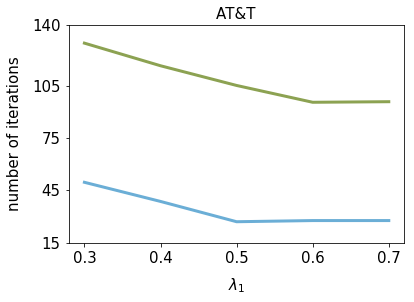

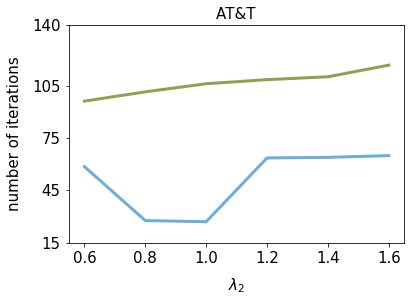

In [7]:
## Plotting the curve
save_fig =  False

med_lbda1_SDPC = res_exp_lbda1['it'][1,:]
med_lbda1_HiLa = res_exp_lbda1['it'][0,:]

out = plt.plot(range_lbda1, med_lbda1_SDPC, label='SDPC', color=cmap1(1), linewidth=3)
out = plt.plot(range_lbda1, med_lbda1_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)
plt.xticks(range_lbda1,fontsize=15)
plt.yticks([15,45,75,105,140], fontsize=15)

plt.tick_params(axis='both', which='major', pad=5)
plt.title('AT&T', fontsize=15)
out = plt.xlabel(r"$\lambda_{1}$", fontsize=15, labelpad=10)
out = plt.ylabel("number of iterations", fontsize=15, labelpad=10)

if save_fig:

    plt.savefig('Figure/ATT_nbit_lbda1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)


plt.show()


med_lbda2_SDPC = res_exp_lbda2['it'][1,:]
med_lbda2_HiLa = res_exp_lbda2['it'][0,:]

out = plt.plot(range_lbda2, med_lbda2_SDPC, label='SDPC', color=cmap1(1), linewidth=3)
out = plt.plot(range_lbda2, med_lbda2_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)
plt.xticks(range_lbda2,fontsize=15)
plt.yticks([15,45,75,105,140], fontsize=15)

plt.tick_params(axis='both', which='major', pad=5)
plt.title('AT&T', fontsize=15)
out = plt.xlabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
out = plt.ylabel("number of iterations", fontsize=15, labelpad=10)

if save_fig:

    plt.savefig('Figure/ATT_nbit_lbda2png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)

plt.show()





## Fig 6

In [11]:
path = 'Savings/ATT/ATT_[0.5,1.0]_b=0.pkl'
with open(path, 'rb') as file:
    res_Hila = pickle.load(file)

path = 'Savings/ATT/ATT_[0.5,1.0]_b=1.pkl'
with open(path, 'rb') as file:
    res_SDPC = pickle.load(file)

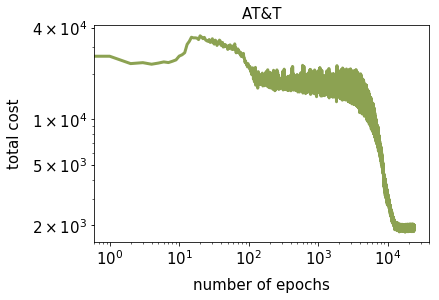

In [14]:
save_fig = False
fig1, ax1 = plt.subplots()

x  = np.arange(10,2500,20)
idx = np.arange(10,25000,200)

reco_Hila = res_Hila['l2_loss'][0] + 0.5*res_Hila['l1_loss'][0] + \
            res_Hila['l2_loss'][1] + 1.0*res_Hila['l1_loss'][1]
reco_SDPC = res_SDPC['l2_loss'][0] + 0.5*res_SDPC['l1_loss'][0] + \
            res_SDPC['l2_loss'][1] + 1.0*res_SDPC['l1_loss'][1]

#out = ax1.plot(reco_SDPC[idx].detach().numpy(), label = '2L_SPC', color=cmap1(1), linewidth=3)
#out = ax1.plot(reco_Hila[idx].detach().numpy(), label='Hi-La', color=cmap2(5), linewidth=3)
out = ax1.plot(reco_Hila.detach().numpy(), label='Hi-La', color=cmap2(5), linewidth=3)

ax1.set_title('AT&T', fontsize=15)
ax1.set_xticks([0,200,400,600,800,1000])
ax1.set_xticklabels([0,200,400,600,800,1000],fontsize=15)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_yticks([2000,5000,10000,40000])
ax1.set_yticklabels([r'$2\times10^3$',r'$5\times10^3$',r'$1\times10^4$', r'$4\times10^4$'],fontsize=15)

out = ax1.set_xlabel("number of epochs", fontsize=15, labelpad=10)
out = ax1.set_ylabel("total cost", fontsize=15, labelpad=10)

if save_fig :
    plt.savefig('Figure/ATT_Loss_training.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)